In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
df = pd.read_csv(r'heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
df['ChestPainType'].value_counts()

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64

In [6]:
df['Sex'].value_counts()

Sex
M    725
F    193
Name: count, dtype: int64

In [7]:
df['RestingECG'].value_counts()

RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64

In [8]:
df['ExerciseAngina'].value_counts()

ExerciseAngina
N    547
Y    371
Name: count, dtype: int64

In [9]:
df['ST_Slope'].value_counts()

ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64

In [10]:
# Separate features and target
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [11]:
# Identify numerical and categorical columns
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
label_encoded_features = ['Sex', 'ExerciseAngina']
one_hot_encoded_features = ['ChestPainType', 'RestingECG', 'ST_Slope']

In [12]:
# Define the transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numerical features
        ('label', OrdinalEncoder(), label_encoded_features),  # Use OrdinalEncoder for binary categorical features
        ('onehot', OneHotEncoder(drop='first'), one_hot_encoded_features)  # One-hot encode other categorical features
    ])

# Apply the transformations
X_transformed = preprocessor.fit_transform(X)

# Convert to DataFrame to see the final result
# Retrieve feature names after transformation for readability
onehot_encoded_columns = preprocessor.named_transformers_['onehot'].get_feature_names_out(one_hot_encoded_features)
column_names = numerical_features + label_encoded_features + list(onehot_encoded_columns)
X_transformed = pd.DataFrame(X_transformed, columns=column_names)

# Display the preprocessed data
X_transformed.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex,ExerciseAngina,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.410909,0.825070,1.382928,-0.832432,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,-0.478484,1.491752,-0.171961,0.754157,0.105664,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,-1.751359,-0.129513,0.770188,-1.525138,-0.832432,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,-0.584556,0.302825,0.139040,-1.132156,0.574711,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.051881,0.951331,-0.034755,-0.581981,-0.832432,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [13]:
X_transformed.shape

(918, 14)

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, 
                                                    test_size=0.20, 
                                                    random_state=47)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((734, 14), (184, 14), (734,), (184,))

##### **Overview:**
* Our custom `SVC` implementation and `sklearn.svm.LinearSVC` (using the liblinear library) both solve the primal form of linear SVM but differ in optimization methods. Our version uses `gradient-based optimization`, while `sklearn.svm.LinearSVC` uses `exact coordinate descent` (closed-form) or `dual coordinate descent` (if dual=True).

In [16]:
# let's code the LinearSVC from scratch

class SVC:
    
    def __init__(self, C: float=1.0, learning_rate: float=0.001, max_iter: int=1000):
        self.C = C
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.losses = []
        
    def compute_loss(self, X, y):
        # compute the regularization term 0.5 * ||w||^2
        regularization_term = 0.5 * np.dot(self.w.T, self.w)
        
        # compute the hinge loss term C * sum(max(0, 1 - y * (Xw + b)))
        distances = 1 - y * (X.dot(self.w) + self.b)  # 1 - y * (Xw + b)
        hinge_loss = np.where(distances > 0, distances, 0)  # max(0, 1 - y * f(X))
        hinge_loss_term = self.C * np.sum(hinge_loss)
        
        # total loss
        total_loss = regularization_term + hinge_loss_term
        return total_loss
    
    def compute_gradients(self, X, y):
        # compute the gradient for w
        distances = 1 - y * (X.dot(self.w) + self.b)  # 1 - y * f(X)
        misclassified = distances > 0  # indicator for hinge loss
        
        # gradient wrt w
        dw = self.w - self.C * X.T.dot(y * misclassified)
        
        # gradient wrt b
        db = -self.C * np.sum(y * misclassified)
        
        return dw, db
    
    def parameters_update(self, dw, db):
        # update weights and bias
        self.w = self.w - (self.learning_rate * dw)
        self.b = self.b - (self.learning_rate * db)
    
    def fit(self, X, y):
        # Convert y from {0, 1} to {-1, +1} if needed
        y = np.where(y == 0, -1, y)
        
        # initialize weights and bias
        n = X.shape[1]
        self.w = np.zeros(n)
        self.b = 0.0
        
        for i in range(self.max_iter):
            # compute and store loss
            loss = self.compute_loss(X, y)
            self.losses.append(loss)
            
            # compute gradients
            dw, db = self.compute_gradients(X, y)
            
            # update parameters
            self.parameters_update(dw, db)
            
            # print progress
            if (i % 100) == 0:
                print(f"Iteration: {i} || Loss: {loss}\n")
    
    def decision_function(self, X):
        # linear decision function: f(x) = Xw + b
        return X.dot(self.w) + self.b
    
    def predict(self, X):
        # predict labels based on the sign of the decision function
        y_pred = np.sign(self.decision_function(X))
        return np.where(y_pred == -1, 0, 1)

In [50]:
model = SVC(
    C=1.0,
    learning_rate=0.001,
    max_iter=1000
)

model.fit(X_train.values, y_train.values)


Iteration: 0 || Loss: 734.0

Iteration: 100 || Loss: 242.3225109137762

Iteration: 200 || Loss: 241.53123728706504

Iteration: 300 || Loss: 241.22243284552013

Iteration: 400 || Loss: 241.10027165011195

Iteration: 500 || Loss: 240.9839968494334

Iteration: 600 || Loss: 240.97697928221174

Iteration: 700 || Loss: 241.02409070192326

Iteration: 800 || Loss: 240.96922173597025

Iteration: 900 || Loss: 240.97127991543755



In [51]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test) 

In [52]:
model.w

array([ 0.14940354,  0.05448105, -0.376616  , -0.00521033,  0.36715445,
        0.93247994,  0.48549652, -1.04933657, -0.95264477, -0.58528469,
        0.09927046,  0.16091223,  1.03062042, -0.61112544])

In [53]:
model.b

-0.5840000000000004

In [54]:
# train set
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       328
           1       0.88      0.90      0.89       406

    accuracy                           0.88       734
   macro avg       0.88      0.87      0.87       734
weighted avg       0.88      0.88      0.88       734



In [55]:
# test set
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.78      0.82        82
           1       0.83      0.89      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



In [23]:
# Plot the cost over iterations
def plot_loss_over_iterations(n_iterations, losses):
    """
    Plots the loss function over iterations.

    Parameters:
    n_iterations (int): Number of iterations.
    loss (list or array-like): Cost values corresponding to each iteration.
    """
    plt.figure(figsize=(6, 4))
    plt.plot(range(n_iterations), losses, linewidth=2, color='b')
    plt.xlabel('Iterations', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.title('Loss Over Iterations', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

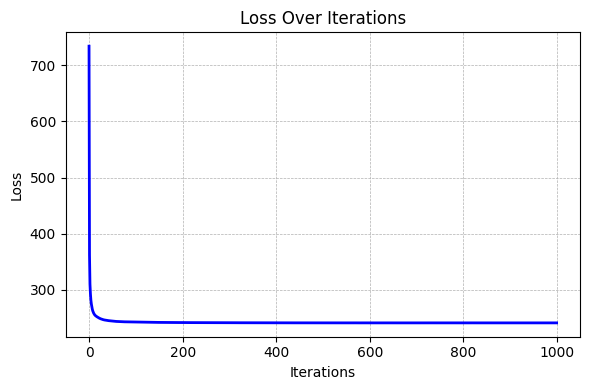

In [56]:
plot_loss_over_iterations(
    n_iterations=model.max_iter,
    losses=model.losses
)

#### **Using `sklearn.svm` `LinearSVC`**

In [25]:
from sklearn.svm import LinearSVC

In [57]:
model1 = LinearSVC(
    C=1.0,
    max_iter=1000,
    dual=False
)

model1.fit(X_train, y_train)

LinearSVC(dual=False)

In [58]:
y_train_pred1 = model1.predict(X_train)
y_test_pred1 = model1.predict(X_test)

In [59]:
# train set
print(classification_report(y_train, y_train_pred1))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       328
           1       0.88      0.90      0.89       406

    accuracy                           0.87       734
   macro avg       0.87      0.87      0.87       734
weighted avg       0.87      0.87      0.87       734



In [61]:
# test set
print(classification_report(y_test, y_test_pred1))

              precision    recall  f1-score   support

           0       0.84      0.79      0.82        82
           1       0.84      0.88      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



In [62]:
model1.coef_

array([[ 0.08629124,  0.03687984, -0.19280004, -0.01768256,  0.159368  ,
         0.44268492,  0.24719513, -0.59687036, -0.50026798, -0.42139698,
         0.0043297 ,  0.00317705,  0.39648258, -0.42473515]])

In [63]:
model.w

array([ 0.14940354,  0.05448105, -0.376616  , -0.00521033,  0.36715445,
        0.93247994,  0.48549652, -1.04933657, -0.95264477, -0.58528469,
        0.09927046,  0.16091223,  1.03062042, -0.61112544])

In [64]:
model1.intercept_

array([-0.107491])

In [65]:
model.b

-0.5840000000000004